<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/JDRath/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.4 MB/s eta 0:00:00


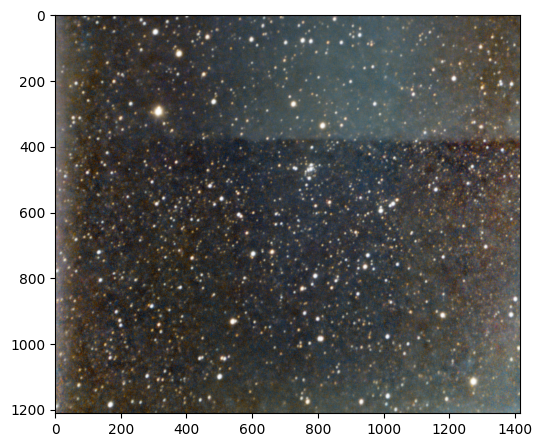

(1211, 1415, 3)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from auto_stretch import apply_stretch
import requests
from io import BytesIO

# Raw file from github.
fits_url = "https://raw.githubusercontent.com/ubsuny/PHY386/main/data/3up.fits"


response = requests.get(fits_url)
response.raise_for_status()


hdul = fits.open(BytesIO(response.content))

rgb_data = np.transpose(hdul[0].data, (1, 2, 0))
hdul.close()

top_margin = 100
bottom_margin = 550
left_margin = 150
right_margin = 350

cropped_rgb = rgb_data[top_margin:rgb_data.shape[0]-bottom_margin,
                       left_margin:rgb_data.shape[1]-right_margin, :]


# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(apply_stretch(cropped_rgb))

plt.show()
cropped_rgb.shape

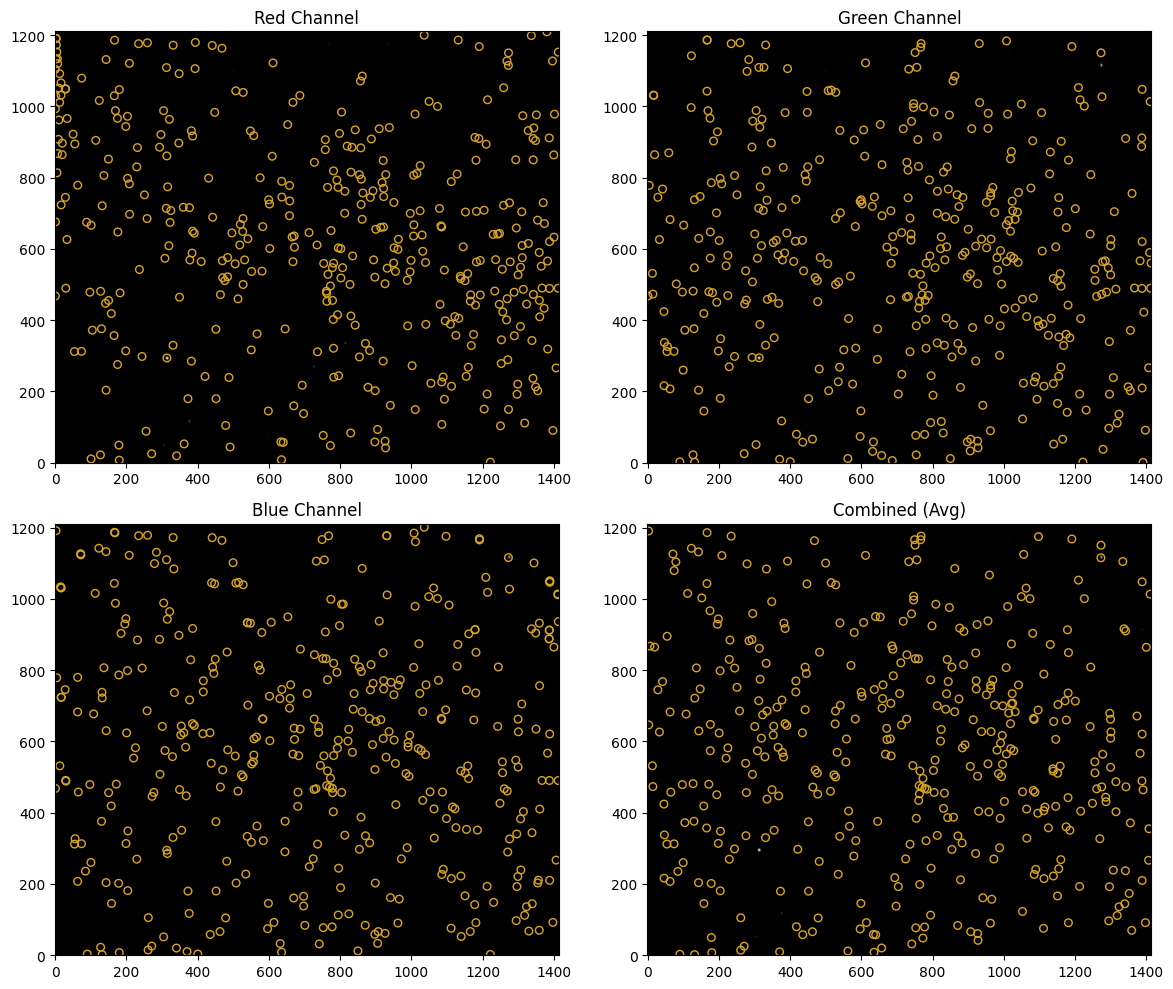

Number of stars detected in Red Channel: 404
Number of stars detected in Green Channel: 404
Number of stars detected in Blue Channel: 404
Number of stars detected in Combined (Avg) Channel: 404


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

# Extract RGB channels separately
R = cropped_rgb[:, :, 0]
G = cropped_rgb[:, :, 1]
B = cropped_rgb[:, :, 2]

# Star detection function
def detect_stars(channel_data, threshold_scale=5.0):
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=threshold_scale * std)
    return finder(channel_data - median)

# Detect stars in each channel
r_sources = detect_stars(R)
g_sources = detect_stars(G)
b_sources = detect_stars(B)

# Equalize number of detected stars across channels
def sample_sources(sources, target_n):
    if sources is None or len(sources) <= target_n:
        return sources
    return sources[np.random.choice(len(sources), target_n, replace=False)]

min_count = min(len(r_sources), len(g_sources), len(b_sources))
r_sources = sample_sources(r_sources, min_count)
g_sources = sample_sources(g_sources, min_count)
b_sources = sample_sources(b_sources, min_count)

# Create average image
avg_channel = np.mean(cropped_rgb, axis=2)
avg_sources = detect_stars(avg_channel)
avg_sources = sample_sources(avg_sources, min_count)

# Plot all channels + average with detected stars
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
titles = ['Red Channel', 'Green Channel', 'Blue Channel', 'Combined (Avg)']
channels = [R, G, B, avg_channel]
sources_list = [r_sources, g_sources, b_sources, avg_sources]

for ax, img, sources, title in zip(axs.flat, channels, sources_list, titles):
    ax.imshow(img, cmap='gray', origin='lower')
    if sources is not None:
        ax.scatter(sources['xcentroid'], sources['ycentroid'], s=30,
                   edgecolor='goldenrod', facecolors='none')
    ax.set_title(title)

plt.tight_layout()
plt.show()

print(f"Number of stars detected in Red Channel: {len(r_sources)}")
print(f"Number of stars detected in Green Channel: {len(g_sources)}")
print(f"Number of stars detected in Blue Channel: {len(b_sources)}")
print(f"Number of stars detected in Combined (Avg) Channel: {len(avg_sources)}")

In [74]:
import numpy as np

# Get the flux (brightness) for each star from each color channel
flux_r = r_sources['flux']
flux_g = g_sources['flux']
flux_b = b_sources['flux']

# Prevent division by zero by replacing 0 values in flux_g with a small number
flux_g_safe = np.where(flux_g == 0, 1e-5, flux_g)  # Replace 0 with a small number to avoid division by zero

# Calculate color ratios (R/G and B/G)
ratio_rg = flux_r / flux_g_safe
ratio_bg = flux_b / flux_g_safe

# Normalize the flux values (scale between 0 and 1)
flux_r_norm = (flux_r - np.min(flux_r)) / (np.max(flux_r) - np.min(flux_r))
flux_g_norm = (flux_g - np.min(flux_g)) / (np.max(flux_g) - np.min(flux_g))
flux_b_norm = (flux_b - np.min(flux_b)) / (np.max(flux_b) - np.min(flux_b))

# Prevent division by zero in normalized flux ratios
flux_g_norm_safe = np.where(flux_g_norm == 0, 1e-5, flux_g_norm)  # Replace 0 with a small number

# Calculate normalized flux ratios
norm_ratio_rg = flux_r_norm / flux_g_norm_safe
norm_ratio_bg = flux_b_norm / flux_g_norm_safe

# Use "sharpness" from red channel as size proxy
size = r_sources['sharpness']
size_norm = (size - np.min(size)) / (np.max(size) - np.min(size))

# Combine all features into one array: each row is a star
# Final feature set: [R/G, B/G, norm R/G, norm B/G, normalized size]
features = np.vstack([
    ratio_rg,
    ratio_bg,
    norm_ratio_rg,
    norm_ratio_bg,
    size_norm
]).T

# Function to remove stars with extreme brightness
def remove_extreme_brightness(star_features, brightness_threshold=3.0):
    brightness = np.linalg.norm(star_features, axis=1)
    mean_brightness = np.mean(brightness)
    std_brightness = np.std(brightness)
    filtered_indices = brightness < (mean_brightness + brightness_threshold * std_brightness)
    return star_features[filtered_indices], filtered_indices

# Remove very bright outlier stars
filtered_features, keep_mask = remove_extreme_brightness(features)

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

# Extract RGB channels separately
R = cropped_rgb[:, :, 0]
G = cropped_rgb[:, :, 1]
B = cropped_rgb[:, :, 2]

# Star detection function
def detect_stars(channel_data, threshold_scale=5.0):
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=threshold_scale * std)
    return finder(channel_data - median)

# Detect stars
r_sources = detect_stars(R)
g_sources = detect_stars(G)
b_sources = detect_stars(B)

# Match number of detections
def sample_sources(sources, n):
    if sources is None or len(sources) <= n:
        return sources
    return sources[np.random.choice(len(sources), n, replace=False)]

min_count = min(len(r_sources), len(g_sources), len(b_sources))
r_sources = sample_sources(r_sources, min_count)
g_sources = sample_sources(g_sources, min_count)
b_sources = sample_sources(b_sources, min_count)

# Feature generation
rg_ratio = np.nan_to_num(r_sources['flux'] / g_sources['flux'], nan=0.0, posinf=0.0, neginf=0.0)
bg_ratio = np.nan_to_num(b_sources['flux'] / g_sources['flux'], nan=0.0, posinf=0.0, neginf=0.0)

rg_norm = (rg_ratio - np.min(rg_ratio)) / (np.max(rg_ratio) - np.min(rg_ratio))
bg_norm = (bg_ratio - np.min(bg_ratio)) / (np.max(bg_ratio) - np.min(bg_ratio))
features = np.vstack([rg_norm, bg_norm]).T

# Autoencoder model
input_layer = Input(shape=(2,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(2, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(2, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=1)

# Output encoded features
encoder = Model(input_layer, encoded)
encoded_features = encoder.predict(features)
print("Encoded features shape:", encoded_features.shape)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2348
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2052
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1702 
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1287 
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0874
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0544
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 16/50
26/

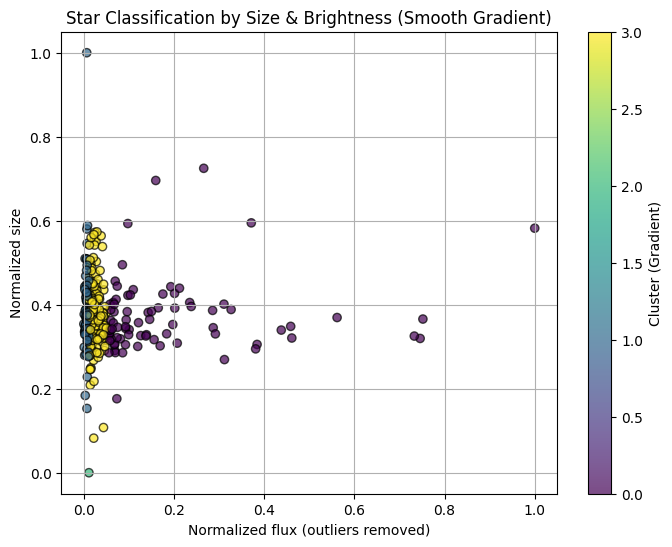

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Extract raw flux and normalize after removing outliers
flux_raw = r_sources['flux']
size_raw = size_norm

# Remove top outliers based on flux
flux_clip_threshold = np.percentile(flux_raw, 99)
mask = flux_raw <= flux_clip_threshold
flux_filtered = flux_raw[mask]
size_filtered = size_raw[mask]

# Normalize the flux after filtering
flux_norm = (flux_filtered - np.min(flux_filtered)) / (np.max(flux_filtered) - np.min(flux_filtered))

# Log-scale transformation
flux_log = np.log10(flux_norm + 1e-5)
size_log = np.log10(size_filtered + 1e-5)

# Stack and scale features
clustering_features = np.vstack([flux_log, size_log]).T
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_features)

# KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(clustering_scaled)

# Normalize labels for smooth colormap
labels_normalized = predicted_labels / (num_clusters - 3)

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(flux_norm, size_filtered, c=labels_normalized,
                      cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized flux (outliers removed)')
plt.ylabel('Normalized size')
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster (Gradient)')
plt.title('Star Classification by Size & Brightness (Smooth Gradient)')
plt.grid(True)
plt.show()

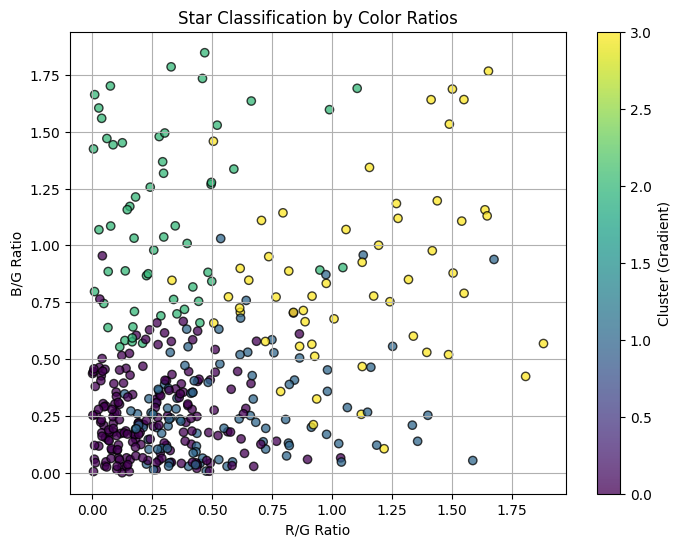

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Access the correct flux column from r_sources, g_sources, b_sources
flux_R = r_sources['flux']
flux_G = g_sources['flux']
flux_B = b_sources['flux']

# Remove extreme flux outliers (99th percentile) across all bands
threshold = np.percentile(np.hstack([flux_R, flux_G, flux_B]), 99)
mask = (flux_R <= threshold) & (flux_G <= threshold) & (flux_B <= threshold)
R = flux_R[mask]
G = flux_G[mask]
B = flux_B[mask]

# Compute color indices
B_V = np.log10(B + 1e-5) - np.log10(G + 1e-5)
V_R = np.log10(G + 1e-5) - np.log10(R + 1e-5)

# Compute color ratios (absolute differences)
B_G_ratio = np.abs(np.log10(B + 1e-5) - np.log10(G + 1e-5))  # Absolute B/G ratio
R_G_ratio = np.abs(np.log10(R + 1e-5) - np.log10(G + 1e-5))  # Absolute R/G ratio

# Stack and scale features
color_features = np.vstack([B_V, V_R]).T
scaler = StandardScaler()
color_scaled = scaler.fit_transform(color_features)

# KMeans clustering
num_clusters = 4
kmeans_color = KMeans(n_clusters=num_clusters, random_state=42)
color_labels = kmeans_color.fit_predict(color_scaled)

# Normalize labels for colorbar
labels_normalized = color_labels / (num_clusters - 3)

# Plot clustering by color ratios
plt.figure(figsize=(8, 6))
scatter = plt.scatter(R_G_ratio, B_G_ratio, c=labels_normalized, cmap='viridis', alpha=0.75, edgecolors='k')
plt.xlabel('R/G Ratio')
plt.ylabel('B/G Ratio')
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster (Gradient)')
plt.title('Star Classification by Color Ratios')
plt.grid(True)
plt.show()